# LightGBM PI analysis

This notebook will illustrate the steps to analyze the predictions of irradiance from the LightGBM model in a probabilistic sense.



## Read data and import libraries
---

Read the prediction data and cluster it into 3 clusters based on the range of pixel values, following the paper.

In [4]:
# create relevent lists

nominal_confident_dict = {0.1: (0.45, 0.55),
                         0.2: (0.4, 0.6),
                         0.3: (0.35, 0.65),
                         0.4: (0.3, 0.7),
                         0.5: (0.25, 0.75),
                         0.6: (0.2, 0.8),
                         0.7: (0.15, 0.85),
                         0.8 : (0.1, 0.91),
                         0.9: (0.05, 0.95),
                         1: (0, 1)
                         }
nominal_confident_list = sorted(list(nominal_confident_dict.keys()))

LB_list = [nominal_confident_dict[e][0] for e in nominal_confident_list]
UB_list = [nominal_confident_dict[e][1] for e in nominal_confident_list]

In [8]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

# Suppress all warnings 
warnings.filterwarnings("ignore")

def cluster_by_bins(df, edge_list, label_list, cols=['R', 'CI']):
    _df = df.copy()
    for col in cols :
        _df[f'{col}_clusters'] = pd.cut(x=_df[col], bins=edge_list, labels=label_list)
    return _df



In [9]:
train_df = pd.read_csv('exp_result/lightgbm_train_result.csv', parse_dates=['Datetime'])
test_df = pd.read_csv('exp_result/lightgbm_test_result.csv', parse_dates=['Datetime'])

preprocessed_train_df = train_df.copy()
preprocessed_test_df = test_df.copy()

# Normalize cloud information

preprocessed_train_df['CI'] = preprocessed_train_df['CI'] / 255
preprocessed_train_df['R'] = preprocessed_train_df['R'] / 255

preprocessed_test_df['CI'] = preprocessed_test_df['CI'] / 255
preprocessed_test_df['R'] = preprocessed_test_df['R'] / 255

In [10]:
cloud_edge_list = [-np.inf, 0.3, 0.7, 1] # [a, b, c] will cluster arr in (a,b] (b, c] by defaultใ
cloud_clusters_list = ['Low cloud', 'Medium cloud', 'High cloud']

hour_edge_list = [6, 9, 14, 18]
hour_clusters_list = ['Morning', 'Noon', 'Evening']

preprocessed_train_df = cluster_by_bins(df=preprocessed_train_df, edge_list=cloud_edge_list,label_list=cloud_clusters_list, cols=['R', 'CI'])
preprocessed_train_df = cluster_by_bins(df=preprocessed_train_df, edge_list=hour_edge_list,label_list=hour_clusters_list, cols=['hour'])

preprocessed_test_df = cluster_by_bins(df=preprocessed_test_df, edge_list=cloud_edge_list,label_list=cloud_clusters_list, cols=['R', 'CI'])
preprocessed_test_df = cluster_by_bins(df=preprocessed_test_df, edge_list=hour_edge_list,label_list=hour_clusters_list, cols=['hour'])

## KDE fitting
---
In this section, we will demonstrate the process of fitting KDE from the predictions of irradiance from the training data and plot the fitted KDE overlay with the actual measurement data from the selected cluster. Finally, in the last , we will fit KDE of all clusters.

In [13]:
# Select 1 cluster to explore
cloud_cluster = 'Low cloud'
hour_cluster = 'Noon'

selected_train_df = preprocessed_train_df[(preprocessed_train_df['R_clusters']==cloud_cluster) & (preprocessed_train_df['hour_clusters']==hour_cluster)]
selected_test_df = preprocessed_test_df[(preprocessed_test_df['R_clusters']==cloud_cluster) & (preprocessed_test_df['hour_clusters']==hour_cluster)]

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

bandwidth=5
data = selected_train_df['I_hat'].dropna().values.reshape(-1, 1)  # Reshape for scikit-learn

# Fit KDE using scikit-learn's KernelDensity
kde = KernelDensity(bandwidth=bandwidth, kernel='gaussian')  # Adjust bandwidth and kernel as needed
kde.fit(data)

# Plot the fitted KDE
x_values = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
log_dens = kde.score_samples(x_values) # get log-likelihood scores for each sample
pdf_values = np.exp(log_dens)
# plt.plot(x_values, pdf_values, color='red', label='fitted Scikit-learn KDE PDF')

# Calculate quantiles directly from the fitted PDF

kde_samples = kde.sample(10000000, random_state=42)
quantiles = np.array([0.05, 0.5, 0.95])
quantile_values = np.percentile(kde_samples, q=quantiles * 100, axis=0)
quantile_training_values = np.percentile(data, q=quantiles * 100, axis=0)

### Examples of the estimated KDE and PI [Fig. 5]

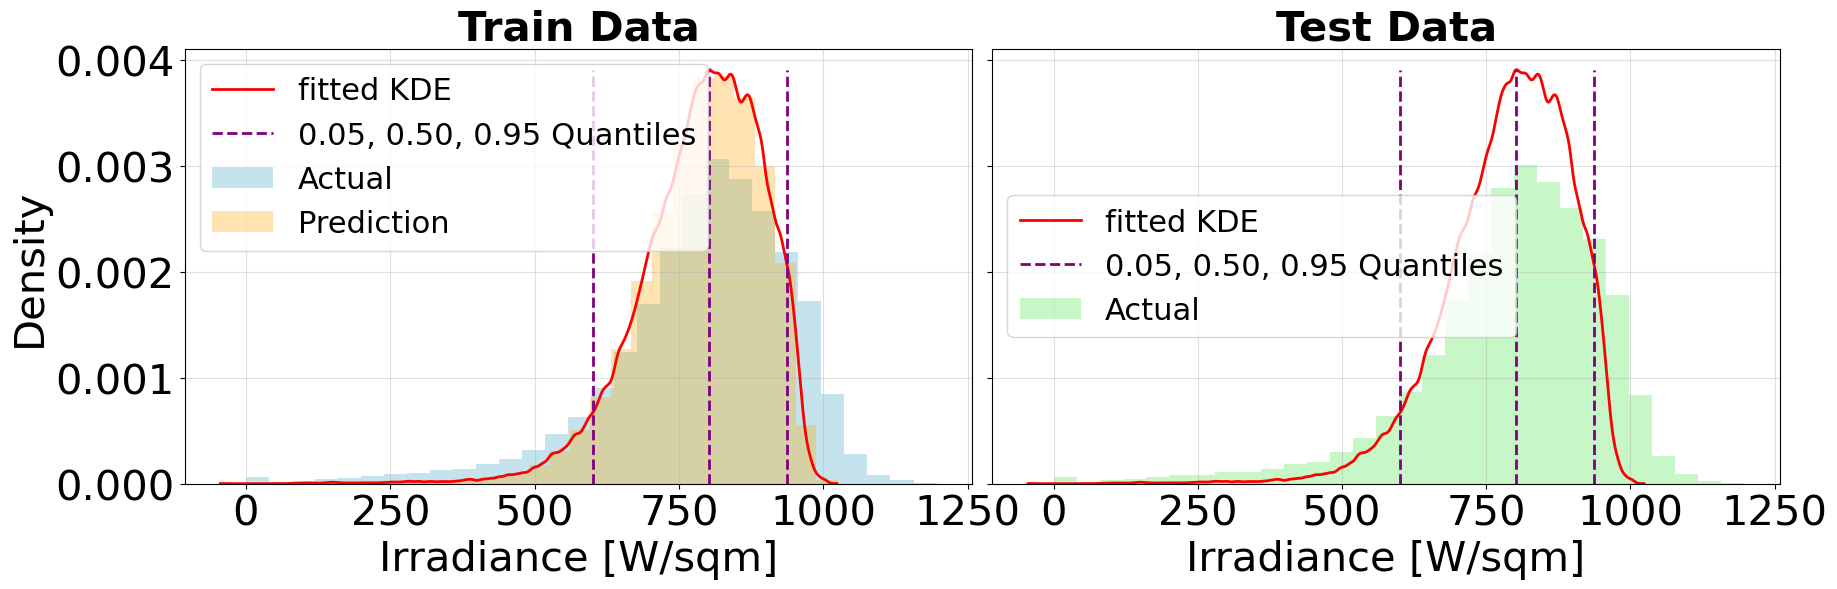

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15*1.2, 5*1.2), sharey=True)
label_size = 30
legend_size = label_size-2
# Plot for Train
axes[0].plot(x_values, pdf_values, color='red', label='fitted KDE', linewidth=2)
axes[0].vlines(quantile_values, ymin=0, ymax=pdf_values.max(), colors='purple', linestyles='dashed', label='0.05, 0.50, 0.95 Quantiles', linewidth=2)
axes[0].hist(selected_train_df['I'].to_numpy(), bins=30, density=True, alpha=0.7, label='Actual', color='lightblue')
axes[0].hist(selected_train_df['I_hat'].to_numpy(), bins=30, density=True, alpha=0.3, label='Prediction', color='orange')
axes[0].set_ylabel('Density', fontsize=label_size)
# Plot for Test
axes[1].plot(x_values, pdf_values, color='red', label='fitted KDE', linewidth=2)
axes[1].vlines(quantile_values, ymin=0, ymax=pdf_values.max(), colors='purple', linestyles='dashed', label='0.05, 0.50, 0.95 Quantiles', linewidth=2)
axes[1].hist(selected_test_df['I'].to_numpy(), bins=30, density=True, alpha=0.5, label='Actual', color='lightgreen')

# Common settings for both plots

for ax in axes:
    ax.set_xlabel('Irradiance [W/sqm]', fontsize=label_size)
    
    ax.legend(fontsize=legend_size-6)
    ax.grid(True, alpha=0.4)
    
    # Set tick label font size
    ax.tick_params(axis='both', labelsize=label_size)

# Set titles
axes[0].set_title('Train Data', fontsize=label_size, weight='bold')
axes[1].set_title('Test Data', fontsize=label_size, weight='bold')

# Show the plot
plt.tight_layout()
plt.show()
# fig.savefig(f'kde_train_test_{cloud_cluster}.pdf')



In [16]:
# Fit all KDE clusters
fitted_kde_dict = {}

for cloud_cluster in cloud_clusters_list:
    for hour_cluster in hour_clusters_list:
        scenario_name = f'{cloud_cluster} at {hour_cluster}'
        condition = (preprocessed_train_df['R_clusters'] == cloud_cluster) & (
            preprocessed_train_df['hour_clusters'] == hour_cluster)
        selected_train_df = preprocessed_train_df[condition]

        data = selected_train_df['I_hat'].dropna().values.reshape(
            -1, 1)  # Reshape for scikit-learn

        # Fit KDE using scikit-learn's KernelDensity
        kde = KernelDensity(
            bandwidth=bandwidth,
            kernel='gaussian')  
        kde.fit(data)
        
        fitted_kde_dict[scenario_name] = kde

## PICP plot [Fig. 6a)]
---
This part we will calculate the PICP of all clusters at each nominal confidence level from the fitted KDE in [KDE fitting](#kde-fitting).

In [17]:
PICP_df = pd.DataFrame()

for cloud_cluster in cloud_clusters_list:
    for hour_cluster in hour_clusters_list:
        scenario_name = f'{cloud_cluster} at {hour_cluster}'
        kde_obj = fitted_kde_dict[scenario_name]
        
        condition = (preprocessed_test_df['R_clusters'] == cloud_cluster) & (
            preprocessed_test_df['hour_clusters'] == hour_cluster)
        
        selected_test_df = preprocessed_test_df[condition]
        
        actual_I_arr = selected_test_df['I'].to_numpy()
        
        PICP_score_cluster = []
        
        for nomial_confident in nominal_confident_list : 
            LB = nominal_confident_dict[nomial_confident][0]
            UB = nominal_confident_dict[nomial_confident][1]
            
            n_samples = 1000000
            kde_samples = kde_obj.sample(n_samples, random_state=42)
            
            LB_quantile = np.percentile(kde_samples, q=LB*100)
            UB_quantile = np.percentile(kde_samples, q=UB*100)
            
            
            PICP_score = np.sum((actual_I_arr>=LB_quantile)&(actual_I_arr<=UB_quantile)) / actual_I_arr.shape[0]
            print(scenario_name,LB_quantile, UB_quantile,PICP_score)
            PICP_score_cluster.append(PICP_score)
        
        PICP_cluster_df = pd.DataFrame({'nominal_confident':nominal_confident_list,'PICP':PICP_score_cluster})
        PICP_cluster_df['R_clusters'] = cloud_cluster
        PICP_cluster_df['hour_clusters'] = hour_cluster
        
        PICP_df = pd.concat([PICP_df,PICP_cluster_df],axis=0, ignore_index=True)

Low cloud at Morning 400.02221434690546 469.0757249744627 0.10260907695680772
Low cloud at Morning 363.82978812221523 501.5844360934299 0.2069721552291164
Low cloud at Morning 328.93292834007786 531.342086399575 0.30109311867698185
Low cloud at Morning 298.1253640145608 559.2255819203003 0.3899520781783444
Low cloud at Morning 261.53696127732337 587.9717710170305 0.48541986406489807
Low cloud at Morning 228.13916101912176 619.6911605211468 0.5851786888840167
Low cloud at Morning 198.13074881558055 653.522395874879 0.6787985090988818
Low cloud at Morning 170.15796891004996 697.4985897857314 0.7756444388761863
Low cloud at Morning 140.72466393027105 728.4237077074341 0.8490306010586651
Low cloud at Morning 13.647536628400534 865.3020560831076 0.9958655683277476
Low cloud at Noon 788.9628846031409 814.8114744885856 0.0783195020746888
Low cloud at Noon 775.5737330525903 827.8024485627419 0.1554431765790687
Low cloud at Noon 761.1854352752904 840.8123168937132 0.23235073766712772
Low cloud 

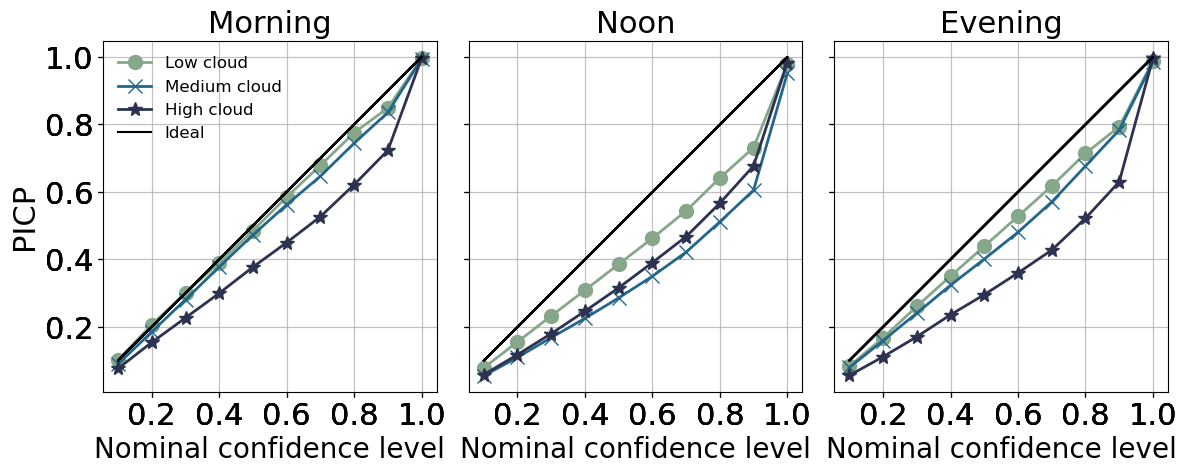

In [20]:
# Get unique values in 'hour_clusters' column

hour_clusters_list = PICP_df['hour_clusters'].unique()
color_list = ['#2D3250', '#22668D', '#86A789'][::-1]
marker_list = ['o', 'x', '*']
color_mapping_dict = dict(zip(cloud_clusters_list, color_list))
marker_mapping_dict = dict(zip(cloud_clusters_list, marker_list))


# Set up the 1x3 subplot grid
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 5), sharey=True)
plot_df = PICP_df[PICP_df['nominal_confident']>=0.1]
font_size = 24

# Iterate through each unique 'hour_clusters' value
for i, hour_cluster in enumerate(hour_clusters_list):
    # Filter data for the current 'hour_clusters' value
    subset_df = plot_df[plot_df['hour_clusters'] == hour_cluster]

    # Iterate through each 'R_clusters' value
    for r_cluster in subset_df['R_clusters'].unique():
        # Filter data for the current 'R_clusters' value
        r_cluster_data = subset_df[subset_df['R_clusters'] == r_cluster]

        # Plot line graph for 'nominal_confident' with the predefined color
        axes[i].plot(r_cluster_data['nominal_confident'],
                     r_cluster_data['PICP'],
                     linewidth=2,
                     markersize=10,
                     color=color_mapping_dict[r_cluster],
                     marker=marker_mapping_dict[r_cluster],
                     label=f'{r_cluster}',
                     )
    # Add a dashed diagonal line (y=x)
    axes[i].plot(subset_df['nominal_confident'], subset_df['nominal_confident'], color='black', label='Ideal')

    # Set x-axis and y-axis labels, and title for each subplot
    axes[i].set_xlabel('Nominal confidence level', fontsize=20)
    axes[i].set_xticks(subset_df['nominal_confident'][1::2])
    axes[i].set_yticks(subset_df['nominal_confident'][1::2])
    axes[i].tick_params(axis='x', labelsize=22)
    axes[i].tick_params(axis='y', labelsize=22)
    axes[i].set_aspect('equal')
    
    if i == 0 :
        axes[i].set_ylabel('PICP', fontsize=22)
        axes[i].legend(loc='upper left', fontsize=12, frameon=False)
    axes[i].set_title(f'{hour_cluster}', fontsize=22)
    axes[i].grid(True, alpha=0.4)

# Show the plot
plt.tight_layout()
plt.show()
# fig.savefig('lgbm_reliability.pdf')

## PI width at nominal confidence = 0.9 [Fig. 6b)]
---
This part we have calculated the PI width for each hour index of each cluster, and then plot only at the nominal confidence level of 0.9 .

In [22]:
PI_width_hour_df = pd.DataFrame()
hour_list = sorted(preprocessed_train_df['hour'].unique())
bandwidth=5
for cloud_cluster in cloud_clusters_list:
    for hour in hour_list:
        condition = (preprocessed_train_df['hour']==hour) & (preprocessed_train_df['R_clusters']==cloud_cluster)
        selected_df = preprocessed_train_df[condition]
        
        data = selected_df['I_hat'].to_numpy().reshape(-1, 1)
        
        # Fit KDE using scikit-learn's KernelDensity
        kde = KernelDensity(
            bandwidth=bandwidth,
            kernel='gaussian')  
        kde.fit(data)
        
        n_samples = 1000000
        kde_samples = kde.sample(n_samples, random_state=42)
        
        LB_quantile = np.percentile(kde_samples, np.array(LB_list)*100)
        UB_quantile = np.percentile(kde_samples, np.array(UB_list)*100)
        
        PI_hour_df = pd.DataFrame({'nominal_confident':nominal_confident_list,'LB_quantile':LB_quantile, 'UB_quantile':UB_quantile})
        PI_hour_df['width'] = PI_hour_df['UB_quantile'] - PI_hour_df['LB_quantile']
        
        PI_hour_df['R_clusters'] =  cloud_cluster
        PI_hour_df['hour'] = hour
        
        PI_width_hour_df = pd.concat([PI_width_hour_df, PI_hour_df], axis=0, ignore_index=True)
        print(f"finish {hour} {cloud_cluster}")        


finish 7 Low cloud
finish 8 Low cloud
finish 9 Low cloud
finish 10 Low cloud
finish 11 Low cloud
finish 12 Low cloud
finish 13 Low cloud
finish 14 Low cloud
finish 15 Low cloud
finish 16 Low cloud
finish 17 Low cloud
finish 7 Medium cloud
finish 8 Medium cloud
finish 9 Medium cloud
finish 10 Medium cloud
finish 11 Medium cloud
finish 12 Medium cloud
finish 13 Medium cloud
finish 14 Medium cloud
finish 15 Medium cloud
finish 16 Medium cloud
finish 17 Medium cloud
finish 7 High cloud
finish 8 High cloud
finish 9 High cloud
finish 10 High cloud
finish 11 High cloud
finish 12 High cloud
finish 13 High cloud
finish 14 High cloud
finish 15 High cloud
finish 16 High cloud
finish 17 High cloud


In [20]:
bar_plot_df = PI_width_hour_df[PI_width_hour_df['nominal_confident']==0.9]
bar_plot_df

,nominal_confident,LB_quantile,UB_quantile,width,R_clusters,hour
8,0.9,107.347098,351.404060,244.056962,Low cloud,7
18,0.9,253.232238,575.964011,322.731773,Low cloud,8
28,0.9,475.352518,762.409559,287.057041,Low cloud,9
38,0.9,641.007306,879.973800,238.966494,Low cloud,10
48,0.9,726.532795,946.677751,220.144956,Low cloud,11
58,0.9,735.588717,957.107022,221.518305,Low cloud,12
68,0.9,655.229178,906.973559,251.744382,Low cloud,13
78,0.9,499.784577,802.630261,302.845684,Low cloud,14
88,0.9,306.727242,640.796778,334.069536,Low cloud,15
98,0.9,145.799543,439.577794,293.778251,Low cloud,16


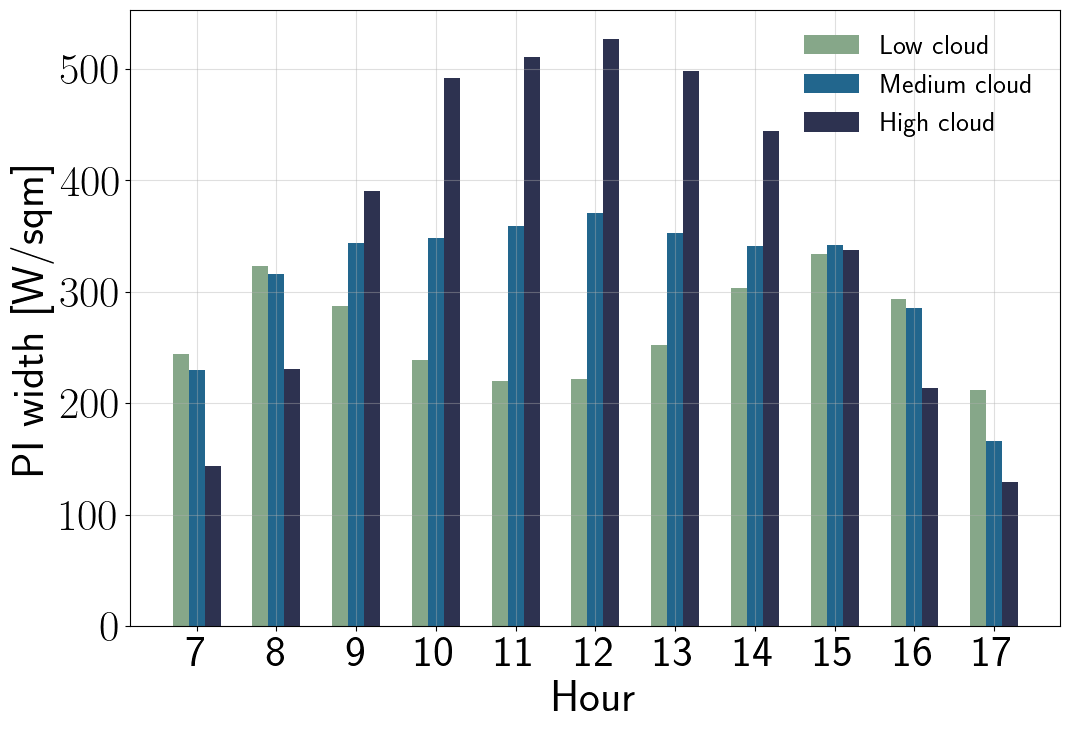

In [21]:
import matplotlib.pyplot as plt

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique hours
hours = sorted(bar_plot_df['hour'].unique())

# Set up bar positions
bar_positions = range(len(hours))

# Set width of each bar
bar_width = 0.2

# Get unique hour clusters
clusters = ['Low cloud', 'Medium cloud', 'High cloud']

# Define three different color sets for each subplot
color_sets = [['#86A789', '#D2E3C8'], ['#22668D', '#8ECDDD'], ['#2D3250', '#7077A1']]



# Plot bars for each hour cluster
for i, cluster in enumerate(clusters):
    cluster_data = bar_plot_df[bar_plot_df['R_clusters'] == cluster]
    positions = [pos + i * bar_width for pos in bar_positions]

    # Use color element 0 if the hour is in the list, otherwise use color element 1
    colors_list = [color_sets[i][0] if hour in [7, 8, 9, 15, 16, 17] else color_sets[i][0] for hour in hours]

    ax.bar(positions, cluster_data['width'], width=bar_width, label=cluster, color=colors_list)

# Set x-axis ticks and labels
ax.set_xticks([pos + bar_width for pos in bar_positions])
ax.set_xticklabels(hours, fontsize=32)
ax.tick_params(axis='y', labelsize=32)
ax.set_xlabel('Hour', fontsize=32)


# Set y-axis label
ax.set_ylabel('PI width [W/sqm]', fontsize=32)
ax.grid(True, alpha=0.4)
# Set legend
ax.legend(fontsize=20, frameon=False)

# Show the plot
plt.show()
# fig.savefig('lgbm_piwidth_by_hour.pdf', dpi=100)

## The alignment between irradiance measurements I and 0.9 confidence PI [Fig. 6c)]
---
From [the calculated PI width](#pi-width-at-nominal-confidence--09-fig-6b), We can sample example days from the actual measurements in the test set and overlay them with the 0.9 confidence PI.

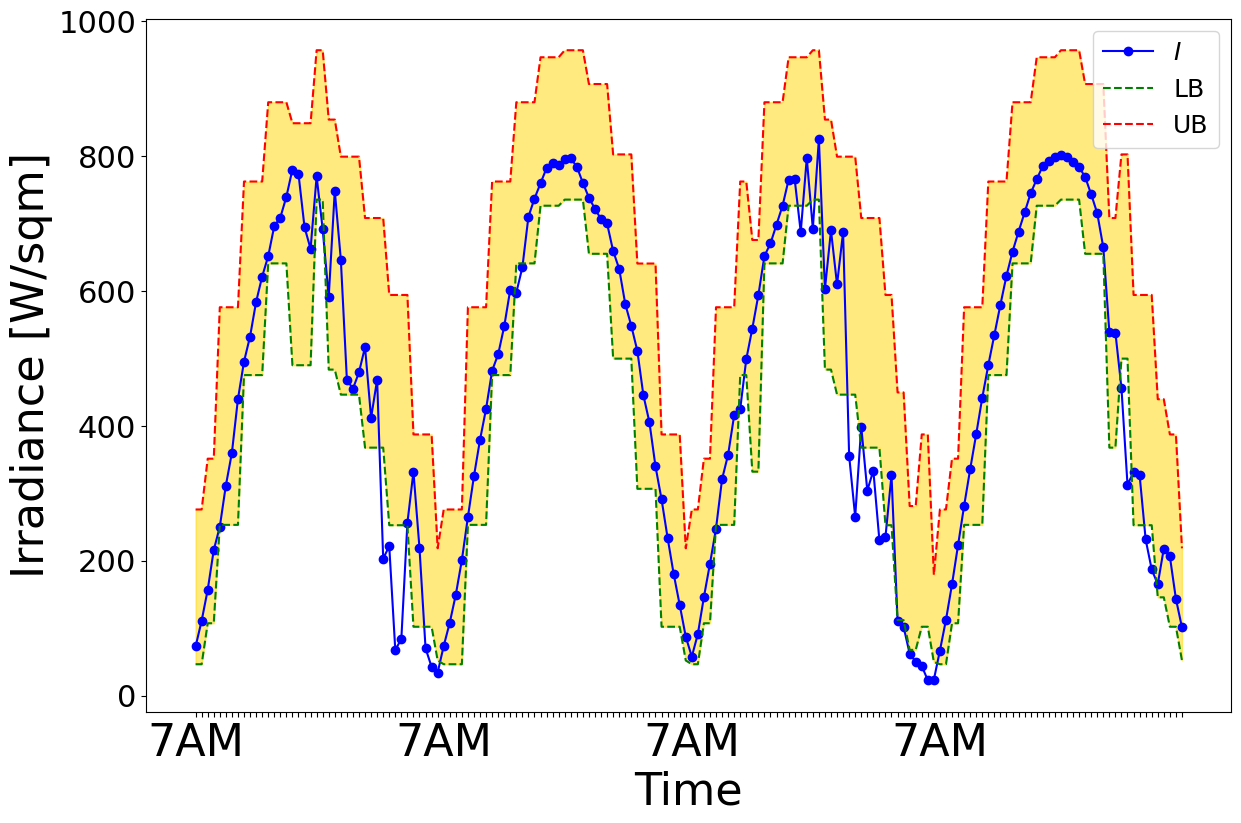

In [23]:
import matplotlib.pyplot as plt

line_plot_df = preprocessed_test_df.merge(PI_width_hour_df, left_on=['R_clusters', 'hour'], right_on=['R_clusters', 'hour'], how='left')
begin = '2022-12-12'
end = '2022-12-18'
site = 'site001'

filtered_data = line_plot_df[(line_plot_df['site_name'] == site)&(line_plot_df['nominal_confident'] == 0.9)]
filtered_data.set_index('Datetime', inplace=True)
filtered_data = filtered_data.loc[begin:end]


plt.figure(figsize=[14,9])
plt.plot(filtered_data.index.map(str),filtered_data['I'].values, '-o', label=r'$I$', color='blue')
plt.plot(filtered_data.index.map(str),filtered_data['LB_quantile'].values, '--', label='LB', color='green')
plt.plot(filtered_data.index.map(str),filtered_data['UB_quantile'].values, '--', label='UB', color='red')
xtick_labels = [f'7AM' if i % 41 == 0 else "" for i in range(filtered_data.shape[0])]

# Filling the area between LB_quantile and UB_quantile
plt.fill_between(filtered_data.index.map(str), filtered_data['LB_quantile'], filtered_data['UB_quantile'], color='gold', alpha=0.5)

plt.xticks(filtered_data.index.map(str), labels=xtick_labels, fontsize=32)


plt.yticks(fontsize=22)# Set the x-ticks to specific time points
plt.legend(loc='upper right',fontsize=18)
# plt.title(f'Point estimated irradiance and 0.9-confidence PI', fontsize=40)
plt.xlabel('Time', fontsize=32)
plt.ylabel('Irradiance [W/sqm]', fontsize=32)
# plt.grid(alpha=0.1)
# plt.savefig('lgbm_prediction.pdf')
plt.show()